<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example-data-on-2021-04-24" data-toc-modified-id="Example-data-on-2021-04-24-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example data on 2021-04-24</a></span><ul class="toc-item"><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Crowd-related metrics</a></span></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-related-metrics" data-toc-modified-id="Shared-control-related-metrics-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Shared control-related metrics</a></span></li></ul></li><li><span><a href="#Archive" data-toc-modified-id="Archive-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Archive</a></span><ul class="toc-item"><li><span><a href="#Crowd" data-toc-modified-id="Crowd-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Crowd</a></span></li><li><span><a href="#Path-Efficiency" data-toc-modified-id="Path-Efficiency-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Path Efficiency</a></span></li><li><span><a href="#Shared-Control" data-toc-modified-id="Shared-Control-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Shared Control</a></span></li></ul></li></ul></div>

# Crowd navigation evaluation

> Analysis of different control methods on different datas

In [1]:
import math
import collections
import urllib.request
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns
sns.set_theme()
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.3})

import sys, os, fnmatch
# Importing Metrics Functions:
# sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'qolo'))

from crowd_evaluation import *
from crowdbot_data import CrowdBotData, CrowdBotDatabase
from notebook_util import walk, violinplot, categorical_plot

%matplotlib inline

In [2]:
qolo_dataset = CrowdBotData()

bagbase = qolo_dataset.bagbase_dir
outbase = qolo_dataset.outbase_dir

print("rosbag database:", bagbase)
print(os.listdir(bagbase))
print()
print("output database:", outbase)
print(os.listdir(outbase))

control_types = ['mds', 'rds', 'shared_control']

rosbag database: /hdd/data_qolo/crowd_qolo_recordings/
['0325_rds', '0410_mds', '0410_rds', '0410_shared_control', '0424_mds', '0424_rds', '0424_shared_control', 'MDS', 'RDS', 'readme.md', 'shared_control', 'shared_test', 'test']

output database: /hdd/data_qolo/crowdbot_data_analysis/
['0410_mds_processed', '0410_rds_processed', '0410_shared_control_processed', '0424_mds_processed', '0424_rds_processed', '0424_shared_control_processed', 'MDS_processed', 'shared_test_processed', 'test_processed']


In [3]:
#!sh data_export_pipeline.sh -e=py38cuda110 -t=shared_test

## Example data on 2021-04-24

In [3]:
example_date = '0424'
eval_dirs = []
for root, dirs, files in walk(bagbase, topdown=False, maxdepth=1):
    for dir in dirs:
        if (example_date in dir):
            eval_dirs.append(dir)
            print("{}/ is available!".format(dir))

0424_mds/ is available!
0424_rds/ is available!
0424_shared_control/ is available!


In [4]:
# for eval_dir in eval_dirs:
eval_dir = eval_dirs[0]
print("Reading results from {}".format(eval_dir))

# new a CrowdBotDatabase() instance
eval_database = CrowdBotDatabase(folder=eval_dir)

Reading results from 0424_mds


In [5]:
print("Available sequences in {}:\n{}".format(eval_dir, eval_database.seqs))

Available sequences in 0424_mds:
['2021-04-24-12-04-04', '2021-04-24-12-07-57', '2021-04-24-12-10-45', '2021-04-24-12-54-04', '2021-04-24-12-56-59', '2021-04-24-13-03-39']


### Crowd-related metrics

In [7]:
crowd_metrics = ('avg_crowd_density5', 
           'avg_crowd_density10', 
           'avg_min_dist',
           'path_lenth2goal',
           'goal_reached',
          )

# more_metrics = (
#     'crowd_density5',
#     'crowd_density10',
#     'min_dist',
# )

frames = []

for eval_dir in eval_dirs:

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(folder=eval_dir)

    m_dict = {'seq': eval_database.seqs}
    m_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    m_dict.update({k: [] for k in metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        crowd_eval_npy = os.path.join(eval_res_dir, seq + "_crowd_eval.npy")
        crowd_eval_dict = np.load(
            crowd_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(crowd_metrics):
            m_dict[crowd_metrics[iidx]].append(crowd_eval_dict[val])

    crowd_df = pd.DataFrame(m_dict)
    crowd_df.columns = ['seq', 'control_type'] + list(crowd_metrics)
    
    # Filter path_lenth2goal less than 10 meter
    crowd_df = crowd_df[crowd_df.path_lenth2goal >= 10.0]

    frames.append(crowd_df)

crowd_metrics_df = pd.concat(frames, ignore_index=True)

Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control


- final dataframe

In [8]:
crowd_metrics_df

,seq,control_type,avg_crowd_density5,avg_crowd_density10,avg_min_dist,path_lenth2goal,goal_reached
0,2021-04-24-12-04-04,mds,0.120290,0.061124,1.004118,20.599373,False
1,2021-04-24-12-07-57,mds,0.093233,0.046961,1.497923,31.204075,True
2,2021-04-24-12-10-45,mds,0.149362,0.069602,1.020987,25.521812,False
3,2021-04-24-12-54-04,mds,0.114009,0.062583,1.195786,29.649303,False
4,2021-04-24-12-56-59,mds,0.137841,0.068062,1.028432,20.827414,False
5,2021-04-24-11-23-43,rds,0.125135,0.063976,1.063080,22.477041,False
6,2021-04-24-11-35-54,rds,0.122445,0.055816,1.215617,22.128941,True
7,2021-04-24-11-40-33,rds,0.161121,0.074358,0.782049,23.956970,True
8,2021-04-24-11-43-54,rds,0.158128,0.066283,0.827276,11.685529,False
9,2021-04-24-11-48-21,rds,0.141997,0.071372,0.853170,21.821390,False


- choose specific control type

In [9]:
crowd_metrics_df[crowd_metrics_df.control_type == 'shared_control']

,seq,control_type,avg_crowd_density5,avg_crowd_density10,avg_min_dist,path_lenth2goal,goal_reached
11,2021-04-24-13-07-54,shared_control,0.149252,0.069288,1.026473,18.816889,False
12,2021-04-24-13-11-03,shared_control,0.140995,0.069307,1.067167,26.770664,True
13,2021-04-24-13-14-49,shared_control,0.157753,0.074547,1.027574,17.272263,False
14,2021-04-24-13-16-58,shared_control,0.169079,0.082017,1.018212,25.977917,False
15,2021-04-24-13-20-05,shared_control,0.165287,0.077891,0.996175,28.863884,False
16,2021-04-24-13-22-52,shared_control,0.141218,0.057149,0.947935,19.624493,False
17,2021-04-24-13-22-52-002,shared_control,0.141218,0.057149,0.947935,19.624493,False
18,2021-04-24-13-25-24-001,shared_control,0.132688,0.064677,1.222095,21.852699,False
19,2021-04-24-13-27-09-003,shared_control,0.114643,0.055257,1.255698,57.629929,False


- calculate std and mean according to `control_type`

In [10]:
# crowd_metrics_df_ = crowd_metrics_df.drop(['seq'], axis=1)

for ctrl in control_types:
    print("###", ctrl)
    print("# mean")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
avg_crowd_density5      0.122947
avg_crowd_density10     0.061666
avg_min_dist            1.149449
path_lenth2goal        25.560396
goal_reached            0.200000
dtype: float64
# std
avg_crowd_density5     0.021734
avg_crowd_density10    0.008962
avg_min_dist           0.209672
path_lenth2goal        4.888370
goal_reached           0.447214
dtype: float64

### rds
# mean
avg_crowd_density5      0.144445
avg_crowd_density10     0.067118
avg_min_dist            0.928207
path_lenth2goal        20.769518
goal_reached            0.333333
dtype: float64
# std
avg_crowd_density5     0.017365
avg_crowd_density10    0.006680
avg_min_dist           0.172050
path_lenth2goal        4.510190
goal_reached           0.516398
dtype: float64

### shared_control
# mean
avg_crowd_density5      0.145792
avg_crowd_density10     0.067476
avg_min_dist            1.056585
path_lenth2goal        26.270361
goal_reached            0.111111
dtype: float64
# std
avg_crowd_density5      0.016898
a

- using sns.violinplot/boxplot

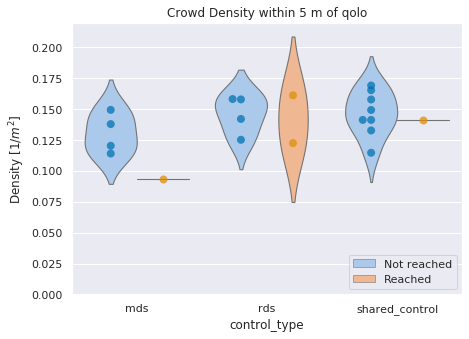

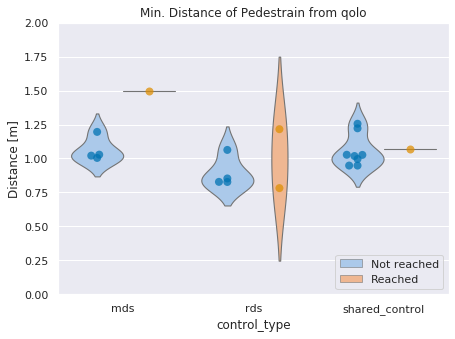

In [11]:
"""
# original
violinplot(axes = axes3,
        df = crowd_metrics_df, 
        metric = 'avg_min_dist', 
        catogory = 'control_type', 
        title = 'Min. Distance of Pedestrain from qolo', 
        ylabel = 'Distance [m]', 
        ylim = [0.0, 3.0])
"""


fig, axes = plt.subplots(figsize=(7, 5))

categorical_plot(
    axes=axes,
    df=crowd_metrics_df,
    metric='avg_crowd_density5',
    catogory='control_type',
    title='Crowd Density within 5 m of qolo',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.22],
    group='goal_reached',
    lgd_labels=['Not reached', 'Reached'],
)

"""
fig2, axes2 = plt.subplots(figsize=(7, 5))

categorical_plot(
    axes=axes2,
    df=crowd_metrics_df,
    metric='avg_crowd_density10',
    catogory='control_type',
    title='Crowd Density within 10 m of qolo',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.15],
    group='goal_reached',
    lgd_labels=['Not reached', 'Reached'],
)
"""

fig3, axes3 = plt.subplots(figsize=(7, 5))

categorical_plot(
    axes=axes3,
    df=crowd_metrics_df,
    metric='avg_min_dist',
    catogory='control_type',
    title='Min. Distance of Pedestrain from qolo',
    ylabel='Distance [m]',
    ylim=[0.0, 2.0],
    group='goal_reached',
    lgd_labels=['Not reached', 'Reached'],
)

### Path Efficiency-related metrics

In [12]:
path_metrics = ('rel_duration2goal', 
                'rel_path_length2goal', 
                'path_lenth2goal',
                'goal_reached',
               )

path_frames = []

for ii, eval_dir in enumerate(eval_dirs):

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(folder=eval_dir)

    pm_dict = {'seq': eval_database.seqs}
    pm_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    pm_dict.update({k: [] for k in path_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        qolo_eval_npy = os.path.join(eval_res_dir, seq + "_qolo_eval.npy")
        qolo_eval_dict = np.load(
            qolo_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(path_metrics):
            pm_dict[path_metrics[iidx]].append(qolo_eval_dict[val])
            # print(iidx, val, path_metrics[iidx])
    # print(pm_dict.keys())
        
    path_df = pd.DataFrame(pm_dict)
    path_df.columns = ['seq', 'control_type'] + list(path_metrics)
    
    # Filter path_lenth2goal less than 10 meter
    path_df = path_df[path_df.path_lenth2goal >= 10.0]

    path_frames.append(path_df)
    
path_metrics_df = pd.concat(path_frames, ignore_index=True)
path_metrics_df.head()

Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control


,seq,control_type,rel_duration2goal,rel_path_length2goal,path_lenth2goal,goal_reached
0,2021-04-24-12-04-04,mds,19.157540,0.744002,20.599373,False
1,2021-04-24-12-07-57,mds,24.901257,0.638410,31.204075,True
2,2021-04-24-12-10-45,mds,21.409329,0.671090,25.521812,False
3,2021-04-24-12-54-04,mds,20.553014,0.554563,29.649303,False
4,2021-04-24-12-56-59,mds,14.485890,0.556416,20.827414,False


In [13]:
for ctrl in control_types:
    print("###", ctrl)
    print("# mean")
    print(path_metrics_df[path_metrics_df.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(path_metrics_df[path_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
rel_duration2goal       20.101406
rel_path_length2goal     0.632896
path_lenth2goal         25.560396
goal_reached             0.200000
dtype: float64
# std
rel_duration2goal       3.787416
rel_path_length2goal    0.080341
path_lenth2goal         4.888370
goal_reached            0.447214
dtype: float64

### rds
# mean
rel_duration2goal       19.966330
rel_path_length2goal     0.771578
path_lenth2goal         20.769518
goal_reached             0.333333
dtype: float64
# std
rel_duration2goal       5.880369
rel_path_length2goal    0.148161
path_lenth2goal         4.510190
goal_reached            0.516398
dtype: float64

### shared_control
# mean
rel_duration2goal       15.207352
rel_path_length2goal     0.682463
path_lenth2goal         26.270361
goal_reached             0.111111
dtype: float64
# std
rel_duration2goal        2.110608
rel_path_length2goal     0.134699
path_lenth2goal         12.424047
goal_reached             0.333333
dtype: float64



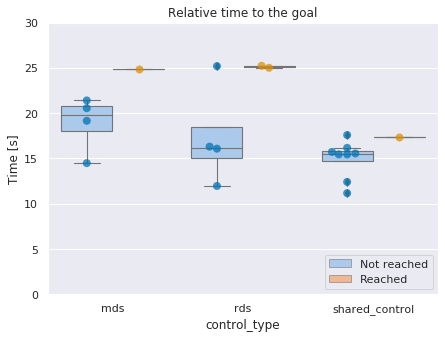

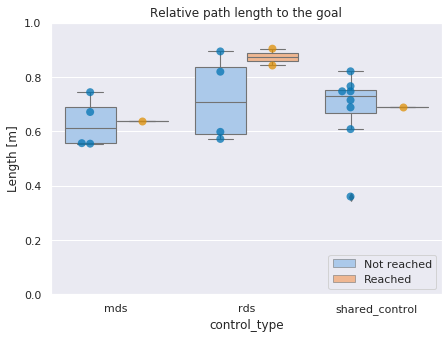

In [14]:
path_fig1, path_axes1 = plt.subplots(figsize=(7, 5))

categorical_plot(
    axes=path_axes1,
    df=path_metrics_df,
    metric='rel_duration2goal',
    catogory='control_type',
    title='Relative time to the goal',
    ylabel='Time [s]',
    ylim=[0.0, 30.0],
    lgd_labels=['Not reached', 'Reached'],
    group='goal_reached',
    kind='box',
)

path_fig2, path_axes2 = plt.subplots(figsize=(7, 5))

categorical_plot(
    axes=path_axes2,
    df=path_metrics_df,
    metric='rel_path_length2goal',
    catogory='control_type',
    title='Relative path length to the goal',
    ylabel='Length [m]',
    ylim=[0.0, 1.0],
    lgd_labels=['Not reached', 'Reached'],
    group='goal_reached',
    kind='box',
)

### Shared control-related metrics

## Archive 

In [4]:
main_dir = os.path.join(os.path.dirname(sys.path[0]), os.pardir)
# print(main_dir)

data_dir = os.path.join(main_dir,'data-crowdbot/')
control_type = ['rds/', 'shared_control/','mds/']
data_type = ['metrics/', 'pose_stamped', 'source_data']

# Testing directories:
fullPath = data_dir+control_type[2]+data_type[0]
print(fullPath)

mds_files = fnmatch.filter(os.listdir(path=fullPath), "*.npy")

print(mds_files)

/home/crowdbot/Documents/yujie/lasa_crowdbot_tools/../data-crowdbot/mds/metrics/


FileNotFoundError: [Errno 2] No such file or directory: '/home/crowdbot/Documents/yujie/lasa_crowdbot_tools/../data-crowdbot/mds/metrics/'

In [30]:
mds_tests = list()
rds_tests = list()
sh_tests = list()

rds_path = data_dir+control_type[0]+data_type[0]
rds_files = fnmatch.filter(os.listdir(path=rds_path), "*.npy")

shared_control_path = data_dir+control_type[1]+data_type[0]
shared_control_files = fnmatch.filter(os.listdir(path=shared_control_path), "*.npy")

mds_path = data_dir+control_type[2]+data_type[0]
mds_files = fnmatch.filter(os.listdir(path=mds_path), "*.npy")

print(rds_files[0])
rds_test = dict()
rds_test = np.load(rds_path+rds_files[0], allow_pickle=True).item()
rds_test['crowd_density10']

# TODO-1: Read the qolo_eval files and extract controller metrics

# print(rds_test['path_lenth2goal'])

2021-04-24-11-20-18_crowd_eval.npy
[0.10185917 0.11459156 0.11777466 ... 0.07321128 0.07957747 0.07957747]


### Crowd 
1. Crowd Density (within an area of 10m around the robot):
evalMetricCrowdDensity(npy_files_directory, plot_result=False)
2. Minimal distance to pedestrians: mean+SD: 
evalMetricProximity(npy_files_directory, plot_result=False):

2. Normalized proximity to surrounding pedestrians : SD(d1..dn) / avg(d1...dn)



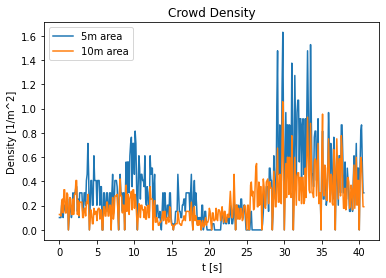

In [ ]:
plot_results = True
flag_tracker = False

test_dir = rds_tests[0]
density_detect = evalMetricCrowdDensity(test_dir,False,plot_results)

# density_track = evalMetricCrowdDensity(test_dir,True,plot_results)

min_dist = evalMetricProximity(test_dir, plot_results)

### Path Efficiency 
1. Relative time to goal (normalized by the goal distance)
2. Relative path length (normalized by the goal distance in straight line): 
evalMetricsPathAndTimeToGoal(npy_files_directory, plot_result=False):

3. Relative Jerk (smoothness of the path as added sum of linear and angular jerk): 


In [ ]:
plot_results = True
# path_length_to_goal, time_duration_to_goal, min_dist (to the Attractor)
evalMetricsPathAndTimeToGoal(test_dir, plot_results)

### Shared Control 
1. Agreement
2. Fluency
3. Entropy

shared_control(npy_files_directory, plot_result=False)

In [ ]:
# metrics['fluency']['mean'] = 

fluency, linear_dis, heading_dis, disagreement = MetricsSharedControl(test_dir, plot_results)
print(linear_dis)
print(heading_dis)